In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.utils.KerasCallbacks import get_callbacks

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'temp/PhaseRegression_tests_CCE_NOaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 4 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize

DIM = [8, 64, 64] # network input params for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [10, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 3 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
OPTIMIZER = 'adam'
LEARNING_RATE = 0.0001
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# Augmentation and Generator params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = False # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = False
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10

# Data paths
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'



Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-02-18 22:18:00,297 INFO -------------------- Start --------------------
2021-02-18 22:18:00,298 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-02-18 22:18:00,298 INFO Log file: ./logs/temp/PhaseRegression_tests_CCE_NOaug.log
2021-02-18 22:18:00,298 INFO Log level for console: INFO
2021-02-18 22:18:00,299 INFO Is built with tensorflow: True
2021-02-18 22:18:00,359 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/PhaseRegression_tests_CCE_NOaug', 'MODEL_PATH': 'models/temp/PhaseRegression_tests_CCE_NOaug/2021-02-18_22_18', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/temp/PhaseRegression_tests_CCE_NOaug/2021-02-18_22_18', 'CONFIG_PATH': 'reports/configs/temp/PhaseRegression_tests_CCE_NOaug/2021-02-18_22_18', 'HISTORY_PATH': 'reports/history/temp/PhaseRegression_tests_CCE_NOaug/2021-02-18_22_18', 'BATCHSIZE': 4, 'GENERATOR_WORKER': 4, 'DIM': [8, 64, 64], 'T_SHAPE': 36, 'SPACING': [10, 3, 3], 'DEPTH': 3, 'FILTERS': 32, 'M_POOL': [1, 2, 2], 'F_SIZE': [3, 3, 3], 'OPTIMIZER': 'adam', 'LEARNING_RATE': 0.0001, 'BN_FIRST': False, 'BATCH_NORMALISATION': True, 'PAD': 'same', 'KERNEL_INIT': 'he_normal', 'ACTIVATION': 'elu', 'DECAY_FACTOR': 0.3, 'MIN_LR': 1e-10, 'BORDER_MODE': 4, 'IMG_INTERPOLATION': 1, 'MSK_INTERPOLATION': 0, 'AUGMENT': False, 'AUGMENT_PROB': 0.8, 'AUGMENT_PHASES': False, 'SHUFFLE': True, 'RESAMPLE': True

2021-02-18 22:18:00,987 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11809421341648004114
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8990766008465820495
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13322766709361297483
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14548357988455695619
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23159039616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7055655442122434147
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23561682304
locality {
  bus_

In [2]:
# zip the phase files in the following structure:
#[[patient1_phase1, patient1_phase2, patient1_phase3, patient1_phase4, patient1_phase5],[patient2_phase1...] ...]

images = sorted(glob.glob('/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/*clean.nrrd'))
print(len(images))

278


In [3]:
images[83]

'/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/0000-91GEVV22_1900-01-01_volume_clean.nrrd'

In [4]:
# check if we find each patient in the corresponding dataframe
import re
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]


for x in images:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))

In [5]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [6]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(images[:220], images[:220], config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(images[220:], images[220:] , config=val_config)

2021-02-18 22:18:02,044 INFO Create DataGenerator
2021-02-18 22:18:02,046 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [10, 3, 3]
 batchsize: 4
 Scaler: MinMax
 Images: 220 
 Augment: False 
 Thread workers: 4
2021-02-18 22:18:02,046 INFO No augmentation
2021-02-18 22:18:02,065 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-02-18 22:18:02,066 INFO Temporal phase augmentation: False
2021-02-18 22:18:02,066 INFO Create DataGenerator
2021-02-18 22:18:02,067 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [10, 3, 3]
 batchsize: 4
 Scaler: MinMax
 Images: 58 
 Augment: False 
 Thread workers: 4
2021-02-18 22:18:02,067 INFO No augmentation
2021-02-18 22:18:02,081 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-02-18 22:18:02,082 INFO Temporal phase augmentation: False


In [7]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(validation_generator)-1, 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_=True):
    
    import time
    global inputs, outputs
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = validation_generator.__getitem__(batch)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_:
    
        selected_input = inputs[im]
        selected_output = outputs[im]

        logging.debug('pad: \n{}'.format(selected_output))
        
        f, axs = plt.subplots(1,2,figsize=(5,5))
        i = 0
        temp_y = selected_output
        ind_gt = np.argmax(temp_y, axis=0)
        axs[0].title.set_text('y')
        axs[0].set_yticks(ind_gt, minor=False)
        axs[0].set_xticks([0,1,2,3,4], minor=False)
        axs[0].set_xticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto')
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        #list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))

        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=7, description='batch', max=14), IntSlider(value=1, description='im', ma…

In [8]:
# test if all batches are processable
"""for b in range(len(validation_generator)-1):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)"""

'for b in range(len(validation_generator)-1):\n    print(b)\n    for im in range(BATCHSIZE):\n        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)'

In [60]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

(None, 8, 8, 8, 256)
(None, 256)
(None, 36, 256)
(None, 8, 8, 8, 256)
(None, 256)
(None, 36, 256)
gap elem 0
(36, 512)
conv1d 32, 1, 1
(None, 36, 256)
conv1d 32 3,1
(None, 36, 50)
(None, 36, 5)


In [51]:
model.summary(line_length=150)

Model: "PhaseRegressionModel"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_8 (InputLayer)                             [(None, 36, 8, 64, 64, 1)]       0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_op_layer_unstack_22 (TensorFlowOpLayer)       [(None, 36, 64, 64, 1), (None, 3 0                 input_8[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv_encoder_15 (ConvEncoder)                    ((None, 36, 8, 

In [61]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=200,
    callbacks = get_callbacks(config, validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=20,
    workers=2,
    use_multiprocessing=False,
    verbose=1)

Epoch 1/200


OperatorNotAllowedInGraphError: in user code:

    /home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /mnt/ssd/git/dynamic-cmr-models/src/utils/Metrics.py:79 meandiff  *
        diffs = np.stack([np.stack(get_min_dist_for_list(gt_idx[i],pred_idx[i])) for i in range(4)])
    /mnt/ssd/git/dynamic-cmr-models/src/utils/Metrics.py:93 get_min_dist_for_list  *
        length = max(max(lst_a), max(lst_b)) + 1
    /home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:503 __iter__  **
        self._disallow_iteration()
    /home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:496 _disallow_iteration
        self._disallow_when_autograph_enabled("iterating over `tf.Tensor`")
    /home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:472 _disallow_when_autograph_enabled
        raise errors.OperatorNotAllowedInGraphError(

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


In [52]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [24]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)
msk = np.stack()

slice_ = tuple(slice(None,elem) for elem in gt_max)
print(outputs.shape)
np.array(outputs[:,slice_,:]).shape

[[23  4  9 13 21]
 [ 0  5 10 15 17]
 [24  4  8 13 20]
 [ 0  6 12 17 18]]
[23 17 24 18]
(4, 36, 5)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [49]:
msk = np.zeros_like(outputs)
print(msk.shape)
print(msk.sum())
msk[:,:max(gt_max),:] = 1
msk.sum()
np.pad(outputs, ())

(4, 36, 5)
0.0


480.0

In [45]:
lens = gt_max
mask = np.arange(36) < lens[None,:,None]
print(mask.shape)
print(mask)
# Setup output array and put elements from data into masked positions
out = np.zeros(mask.shape, dtype=data.dtype)
out[mask] = np.concatenate(data)

(1, 4, 36)
[[[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True  True
    True False False False False False False False False False False
   False False False]
  [ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True False False False False False
   False False False False False False False False False False False
   False False False]
  [ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True  True
    True  True False False False False False False False False False
   False False False]
  [ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True False False False False
   False False False False False False False False False False False
   False False False]]]


NameError: name 'data' is not defined

In [37]:
softargmax(outputs)

<tf.Tensor: shape=(36, 5), dtype=float32, numpy=
array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  2. ,  0. ,  0. ,  0. ],
       [ 0. ,  3.5,  0. ,  0. ,  0. ],
       [ 0. ,  4. ,  0. ,  0. ,  0. ],
       [ 0. ,  4. ,  0. ,  0. ,  0. ],
       [ 0. ,  3.5,  1. ,  0. ,  0. ],
       [ 0. ,  2. ,  4. ,  0. ,  0. ],
       [ 0. ,  1. ,  6. ,  0. ,  0. ],
       [ 0. ,  0.5,  7. ,  0. ,  0. ],
       [ 0. ,  0. ,  8. ,  0. ,  0. ],
       [ 0. ,  0. ,  5. ,  4.5,  0. ],
       [ 0. ,  0. ,  4. ,  6. ,  0. ],
       [ 0. ,  0. ,  2. ,  9. ,  0. ],
       [ 0. ,  0. ,  2. ,  9. ,  0. ],
       [ 0. ,  0. ,  0. , 12. ,  0. ],
       [ 0. ,  0. ,  0. , 10.5,  2. ],
       [ 0. ,  0. ,  0. ,  4.5, 10. ],
       [ 0. ,  0. ,  0. ,  0. , 16. ],
       [ 0. ,  0. ,  0. ,  0. , 12. ],
       [ 0. ,  0. ,  0. ,  0. ,  8. ],
       [ 0. ,  0. ,  0. ,  0. ,  8. ],
       [ 0. ,  0. ,  0. ,  0. ,  4. ],
       [ 0. ,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  

In [34]:
def softargmax(x, beta=1e10):
    x = tf.convert_to_tensor(x)
    x_range = tf.range(x.shape.as_list()[-1], dtype=x.dtype)
    return tf.reduce_sum(tf.nn.softmax(x*beta) * x_range, axis=0)

[23  4  9 13 19]
[23  4  9 13 21]
[ 0  4  8 12 16]
[19  4  8 12 17]
[ 0  3  7 10 13]
[ 0  4  7 10 13]
[ 0  4  8 12 17]
[19  4  8 13 16]


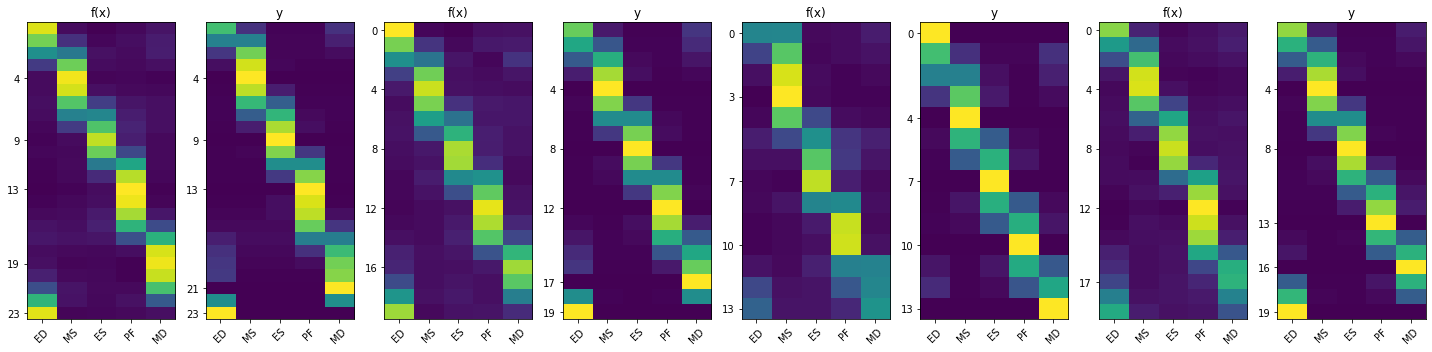

In [79]:
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
# get the true idx

gt_max = gt_idx.max(axis=1)

f, axs = plt.subplots(1,BATCHSIZE*2,figsize=(5*BATCHSIZE,5))
i = 0
for cutoff,idx in zip(gt_max,range(BATCHSIZE)):
    cutoff = cutoff + 1
    axs[i].title.set_text('f(x)')
    temp_pred = pred[idx][:cutoff,:].numpy()
    #temp_pred = pred[idx].numpy()
    ind = np.argmax(temp_pred, axis=0)
    print(ind)
    axs[i].set_yticks(ind, minor=False)
    axs[i].set_xticks([0,1,2,3,4], minor=False)
    axs[i].set_xticklabels(phases, rotation =45)
    axs[i].imshow(temp_pred, aspect='auto')
    i = i+1
    axs[i].title.set_text('y')
    temp_y = outputs[idx][:cutoff,:]
    #temp_y = outputs[idx]
    ind_gt = np.argmax(temp_y, axis=0)
    axs[i].set_yticks(ind_gt, minor=False)
    axs[i].set_xticks([0,1,2,3,4], minor=False)
    axs[i].set_xticklabels(phases, rotation =45)
    print(ind_gt)
    axs[i].imshow(temp_y, aspect='auto')
    i = i+1
f.tight_layout()

In [57]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn(outputs, outputs).numpy()

0.0

In [77]:
# transform the lis tof indicies into binary representation
# by this we could get the ring functionality?
#[ 0  4  8 12 16]
# 19  4  8 12 17]

print(np.argmax(outputs[1], axis=0))
print(np.argmax(pred[1], axis=0))

temp = np.tile(outputs[1], (2,1))
temp2 = np.tile(pred[1], (2,1))

print(temp.shape)
print(temp2.shape)
print(np.argmax(temp, axis=0))
print(np.argmax(temp2, axis=0))

[19  4  8 12 17]
[ 0  4 29 12 16]
(72, 5)
(72, 5)
[19  4  8 12 17]
[ 0  4 29 12 16]


In [92]:
def get_min_distance(a,b,mod):
    decr_counter = 0
    incr_counter = 0
    
    smaller = min(a,b)
    bigger = max(a,b)

    res = list(range(mod))
    print(res)
    i1 =bigger
    while(res[i1]!=smaller):
        decr_counter = decr_counter+1
        i1 = i1-1

    i1 = bigger
    while(res[i1]!=smaller):
        incr_counter = incr_counter+1
        i1 = (i1+1)%mod

    return min(decr_counter, incr_counter)
    
    
get_min_distance(4,18,19)
    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


5

In [99]:
# calculate the meandiff score for all batches
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

[<tf.Tensor: shape=(), dtype=float32, numpy=3.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.75>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.75>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.75>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.75>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.75>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=9.5>]

In [100]:
tf.reduce_mean(scores).numpy()

3.3666666

# Generator tests

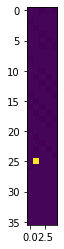

In [9]:
temp = outputs[2][:]
plt.imshow(temp)

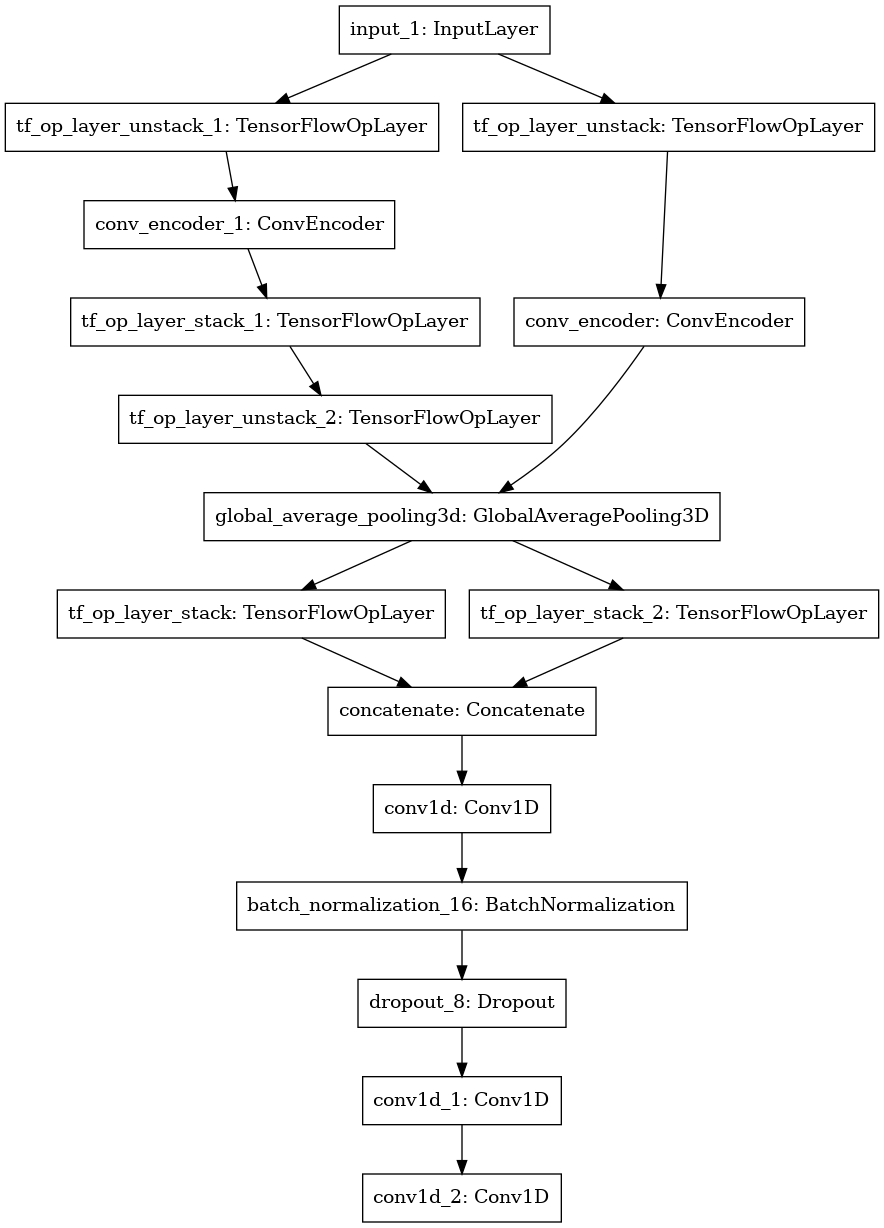

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [11]:
temp = outputs[2][:]
print(temp.shape)
print(temp)
print('axis = 0: {}'.format(temp.sum(axis=0)))
print('axis = 1: {}'.format(temp.sum(axis=1)))


(36, 5)
[[ 1.38348091e+00  1.23632700e+34 -1.81182511e+36  4.56599092e-41
  -1.81926115e+36]
 [ 4.56599092e-41  3.22819804e-03 -6.46831612e-31 -2.99579847e-29
   4.56613105e-41]
 [-1.81928397e+36  4.56599092e-41  6.13270337e-11 -2.39915704e+10
  -2.78123062e-29]
 [ 4.56613105e-41 -1.81930679e+36  4.56599092e-41  1.01344287e+04
   8.43546880e+07]
 [-1.99690347e-16  4.56613105e-41 -1.81932961e+36  4.56599092e-41
  -4.54529307e+33]
 [-6.16835742e+04 -1.04216684e-17  4.56613105e-41 -1.81935242e+36
   4.56599092e-41]
 [-2.90389409e-07 -6.48057959e+03 -1.81197723e+36  4.56599092e-41
  -1.81937524e+36]
 [ 4.56599092e-41 -4.12825109e+26  4.77408846e-17 -1.38908956e-16
   4.56613105e-41]
 [-1.81939806e+36  4.56599092e-41 -1.45753474e+18 -2.60766018e-02
  -1.38886934e-16]
 [ 4.56613105e-41 -1.33684881e-16  4.56613105e-41 -9.35618770e-27
   7.34581107e-15]
 [-1.97438086e-16  4.56613105e-41 -1.81944369e+36  4.56599092e-41
   2.14501761e-05]
 [ 1.19029230e-17 -1.81186568e+36  4.56599092e-41 -1.8194

In [22]:
lst = [1,2,3,4,5,6,7,8,9]
first = lst[3:]
first.extend(lst[:3])
first

[4, 5, 6, 7, 8, 9, 1, 2, 3]

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)